## Auto Regressive for Feature Extraction by Lags of time series 
 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
%matplotlib inline

import mne

## Here P = 15

In [2]:
import glob


path = r'Pre_Processed data' # use your path
all_files = glob.glob(path + "/*.fif")

li = []
cols = []
sub = 1
for filename in all_files:
    raw =  mne.io.read_raw_fif(filename);
    raw.crop(tmin=50, tmax=165)
    if 'CH 4' in raw.info['ch_names']:
        li.append(pd.Series(raw.get_data()[0]).shift(15)) # Here P = 15
        cols.append(str(sub)+'_CH4')
    sub += 1    
frame = pd.concat(li, axis=1, ignore_index=True, sort=False)
frame.columns = cols
frame.dropna(inplace=True)

Opening raw data file C:\Users\sonal\EEG\Pre_Processed data\Subject-1_Non-VR.fif...
Isotrak not found
    Range : 1280 ... 22400 =     10.000 ...   175.000 secs
Ready.


<ipython-input-2-e12de519fd85>:11: RuntimeWarning: This filename (C:\Users\sonal\EEG\Pre_Processed data\Subject-1_Non-VR.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw =  mne.io.read_raw_fif(filename);


Opening raw data file C:\Users\sonal\EEG\Pre_Processed data\Subject-1_VR.fif...
Isotrak not found
    Range : 1280 ... 22400 =     10.000 ...   175.000 secs
Ready.
Opening raw data file C:\Users\sonal\EEG\Pre_Processed data\Subject-2_Non-VR.fif...
Isotrak not found
    Range : 1280 ... 22400 =     10.000 ...   175.000 secs
Ready.
Opening raw data file C:\Users\sonal\EEG\Pre_Processed data\Subject-2_VR.fif...
Isotrak not found
    Range : 1280 ... 22400 =     10.000 ...   175.000 secs
Ready.


<ipython-input-2-e12de519fd85>:11: RuntimeWarning: This filename (C:\Users\sonal\EEG\Pre_Processed data\Subject-1_VR.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw =  mne.io.read_raw_fif(filename);
<ipython-input-2-e12de519fd85>:11: RuntimeWarning: This filename (C:\Users\sonal\EEG\Pre_Processed data\Subject-2_Non-VR.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw =  mne.io.read_raw_fif(filename);
<ipython-input-2-e12de519fd85>:11: RuntimeWarning: This filename (C:\Users\sonal\EEG\Pre_Processed data\Subject-2_VR.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw =  mne.io.read_raw_fif(filename);


In [3]:
df = frame
df.reset_index(drop=True, inplace=True)
df.head()

,1_CH4,2_CH4,3_CH4,4_CH4
0,1.117504,1.306901,7.612332,10.929424
1,-0.464787,-6.590934,11.801425,7.699463
2,-10.701982,-2.046821,8.125918,2.277603
3,-7.806469,-0.352435,3.246489,4.293180
4,12.922297,-5.471541,7.532561,5.807290


## Data Normalization

In [4]:
df_norm = (df - df.mean()) / (df.max() - df.min())
df_norm.head()

,1_CH4,2_CH4,3_CH4,4_CH4
0,0.005458,0.005877,0.003013,0.058686
1,-0.002249,-0.029649,0.004672,0.041338
2,-0.052113,-0.009209,0.003217,0.012217
3,-0.038009,-0.001587,0.001285,0.023043
4,0.062957,-0.024614,0.002982,0.031175


In [5]:
df_norm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14706 entries, 0 to 14705
Data columns (total 4 columns):
1_CH4    14706 non-null float64
2_CH4    14706 non-null float64
3_CH4    14706 non-null float64
4_CH4    14706 non-null float64
dtypes: float64(4)
memory usage: 459.6 KB


## Dichotomizer

In [6]:
import itertools

In [7]:
# Note: For sample i am taking here only 6(0-5) rows. Actual data (14706) may take long time to execute. 

rows = len(df_norm.index[:6]) #All sample numbers(number of rows)
subs = df_norm.columns # All subjects


each_comb = list(itertools.combinations(range(rows), 2)) #All possible combinaion for all rows(All samples)

all_subs= list(itertools.combinations(subs, 2)) # All possible combination for all subjects


Intra_data = []
Inter_data = []

A, B, dist,target = [],[],[],[]

#Intra-distacne: Same person
for sub in subs: # subjects
    for i in range(len(each_comb)):# passing random sample pairs for each subject
        x1= each_comb[i][0] # Time(index) of  1st feature 
        y1= each_comb[i][1] # Time(index) of 2st feature
        x2 = df_norm[sub][each_comb[i][0]] # 1st feature value
        y2 = df_norm[sub][each_comb[i][1]] # 2nd feature value
        Intra_dis = ((x1-y1)**2 + (x2-y2)**2) ** 0.5 # Euclidian distance formula
        Intra_data.append(Intra_dis)
        A.append(x2)
        B.append(y2)
        dist.append(Intra_dis)
        target.append(0)
        
        
# Inter-distacne: Different peron 
for sub_pair in all_subs: # Random Pair of subjets
    for i in range(rows): # looping for sample
        x1 = i  # same time for both feature 
        y1 = i  # same time for both feature
        x2 = df_norm[sub_pair[0]][i] # Feature for subject 1 according to pair
        y2 = df_norm[sub_pair[1]][i] # Feature for subject 2 according to pair
        Inter_dis = ((x1-y1)**2 + (x2-y2)**2) ** 0.5 # Euclidian distance formula
        Inter_data.append(Inter_dis)
        A.append(x2)
        B.append(y2)
        dist.append(Intra_dis)
        target.append(1)
             
final_df = pd.DataFrame([A,B,dist,target])
final_df = final_df.T
final_df.columns = ['A','B', 'dist','target']

final_df

,A,B,dist,target
0,0.005458,-0.002249,1.000030,0.0
1,0.005458,-0.052113,2.000828,0.0
2,0.005458,-0.038009,3.000315,0.0
3,0.005458,0.062957,4.000413,0.0
4,0.005458,0.170771,5.002732,0.0
5,-0.002249,-0.052113,1.001242,0.0
6,-0.002249,-0.038009,2.000320,0.0
7,-0.002249,0.062957,3.000709,0.0
8,-0.002249,0.170771,4.003740,0.0
9,-0.052113,-0.038009,1.000099,0.0


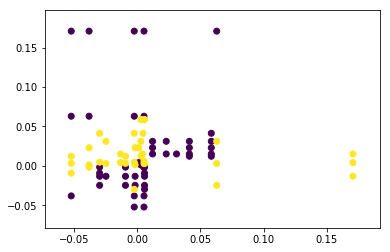

In [8]:
plt.scatter('A','B',data=final_df,c='target')

In [9]:
from sklearn.model_selection import train_test_split

In [10]:
X = final_df.drop('target', axis=1)
y = final_df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

In [11]:
from sklearn.svm import SVC

In [12]:
model = SVC()

In [13]:
model.fit(X_train, y_train)

c:\users\sonal\appdata\local\programs\python\python37\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [14]:
prediction = model.predict(X_test)

In [15]:
from sklearn.metrics import confusion_matrix, classification_report

In [16]:
print(confusion_matrix(y_test, prediction))

[[17  5]
 [ 0  7]]


In [17]:
print(classification_report(y_test, prediction))

              precision    recall  f1-score   support

         0.0       1.00      0.77      0.87        22
         1.0       0.58      1.00      0.74         7

   micro avg       0.83      0.83      0.83        29
   macro avg       0.79      0.89      0.80        29
weighted avg       0.90      0.83      0.84        29

